In [1]:
# 필요한 모듈 임포트
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd

In [2]:
# 기상관측 자료 로딩
obs_list = pd.read_csv('/content/기상정보_2021.csv', encoding='euc-kr')
obs_list

,지점,지점명,일시,최고기온(°C),최대 순간 풍속(m/s)
0,90,속초,2021-01-01,1.2,9.8
1,90,속초,2021-01-02,1.5,8.7
2,90,속초,2021-01-03,0.7,12.5
3,90,속초,2021-01-04,3.2,8.7
4,90,속초,2021-01-05,0.1,12.4
...,...,...,...,...,...
34663,295,남해,2021-12-27,3.9,9.7
34664,295,남해,2021-12-28,8.7,7.6
34665,295,남해,2021-12-29,10.6,14.2
34666,295,남해,2021-12-30,5.6,14.3


In [3]:
# 데이터 컬럼 및 타입 확인
obs_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34668 entries, 0 to 34667
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   지점             34668 non-null  int64  
 1   지점명            34668 non-null  object 
 2   일시             34668 non-null  object 
 3   최고기온(°C)       34658 non-null  float64
 4   최대 순간 풍속(m/s)  34643 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.3+ MB


In [4]:
# 컬럼명 변경
obs_list.columns = ['지점','지점명','일시','최고기온','최고풍속']

In [5]:
# 데이터 타입 변경
obs_list['지점'] = obs_list['지점'].astype(object)
obs_list['지점명'] = obs_list['지점명'].astype(object)
obs_list['최고기온'] = obs_list['최고기온'].astype(float)
obs_list['최고풍속'] = obs_list['최고풍속'].astype(float)
obs_list['일시'] = pd.to_datetime(obs_list['일시'], format='%Y-%m-%d')
obs_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34668 entries, 0 to 34667
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   지점      34668 non-null  object        
 1   지점명     34668 non-null  object        
 2   일시      34668 non-null  datetime64[ns]
 3   최고기온    34658 non-null  float64       
 4   최고풍속    34643 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 1.3+ MB


In [6]:
# 화재발생 시군구와 매칭하기 위하여 기상관측지점명 전체 집합(Set) 생성
obs_branch_set = set(obs_list['지점명'])
print(len(obs_branch_set))
print(obs_branch_set)

95
{'태백', '여수', '경주시', '해남', '제주', '서울', '진주', '문경', '완도', '영월', '부산', '봉화', '거제', '합천', '밀양', '대전', '북춘천', '금산', '울릉도', '양산시', '진도군', '부여', '목포', '천안', '강화', '울진', '동해', '서귀포', '임실', '파주', '흑산도', '보령', '전주', '인천', '정선군', '안동', '세종', '광주', '구미', '의성', '춘천', '부안', '산청', '함양군', '강릉', '추풍령', '순천', '울산', '철원', '김해시', '순창군', '북강릉', '서산', '성산', '양평', '북창원', '거창', '이천', '제천', '강진군', '영덕', '창원', '보은', '영주', '홍천', '영광군', '홍성', '남원', '충주', '고창군', '영천', '군산', '장흥', '청주', '대관령', '보성군', '고흥', '포항', '정읍', '동두천', '통영', '청송군', '인제', '수원', '남해', '상주', '백령도', '원주', '광양시', '의령군', '속초', '장수', '고창', '고산', '대구'}


In [19]:
# 소방청 국가화재정보 시도단위 화재발생현황목록 로딩
fire_list = pd.read_csv('/content/화재발생 정보_2021.csv', encoding='euc-kr')
fire_list

,화재발생년월일,시도,시군구,인명피해소계,사망,부상,재산피해소계,부동산,동산,장소대분류,장소중분류,장소소분류
0,2021-01-01 00:00,서울특별시,구로구,0,0,0,50,0.0,50.0,산업시설,공장시설,금속기계 및 기구공업
1,2021-01-01 00:05,광주광역시,광산구,0,0,0,146,86.0,60.0,산업시설,공장시설,"전기, 전자공업"
2,2021-01-01 00:06,광주광역시,광산구,1,1,0,5148,5111.0,37.0,"판매,업무시설",일반업무,오피스텔
3,2021-01-01 00:07,경기도,여주시,0,0,0,62588,35620.0,26968.0,생활서비스,음식점,한식
4,2021-01-01 00:12,경기도,양평군,0,0,0,118081,87509.0,30572.0,산업시설,동식물시설,계사
...,...,...,...,...,...,...,...,...,...,...,...,...
36262,2021-12-31 22:54,경기도,평택시,0,0,0,786,562.0,224.0,주거,단독주택,다가구주택
36263,2021-12-31 23:07,전라북도,장수군,0,0,0,363,349.0,14.0,주거,단독주택,단독주택
36264,2021-12-31 23:09,전라남도,고흥군,0,0,0,63,63.0,0.0,주거,기타주택,기타 주택
36265,2021-12-31 23:25,경상북도,포항시남구,0,0,0,8470,0.0,8470.0,"자동차,철도차량",자동차,버스


In [20]:
fire_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36267 entries, 0 to 36266
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   화재발생년월일  36267 non-null  object 
 1   시도       36267 non-null  object 
 2   시군구      36267 non-null  object 
 3   인명피해소계   36267 non-null  int64  
 4   사망       36267 non-null  int64  
 5   부상       36267 non-null  int64  
 6   재산피해소계   36267 non-null  int64  
 7   부동산      33438 non-null  float64
 8   동산       33438 non-null  float64
 9   장소대분류    36267 non-null  object 
 10  장소중분류    36267 non-null  object 
 11  장소소분류    36267 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 3.3+ MB


In [21]:
# 학습에 필요없는 컬럼 제거
fire_list.drop(['사망', '부상', '인명피해소계', '시도', '장소대분류', '부동산', '동산', '장소대분류', '장소중분류', '장소소분류'],axis=1,inplace=True)
fire_list

,화재발생년월일,시군구,재산피해소계
0,2021-01-01 00:00,구로구,50
1,2021-01-01 00:05,광산구,146
2,2021-01-01 00:06,광산구,5148
3,2021-01-01 00:07,여주시,62588
4,2021-01-01 00:12,양평군,118081
...,...,...,...
36262,2021-12-31 22:54,평택시,786
36263,2021-12-31 23:07,장수군,363
36264,2021-12-31 23:09,고흥군,63
36265,2021-12-31 23:25,포항시남구,8470


In [22]:
# 기상관측자료의 관측일시(연월일만 존재)와 매칭하기 위해서 화재발생년월일 중 시간 정보 삭제
def date_convert(x):
  split_x = x.split()
  return split_x[0]

fire_list['화재발생년월일']=fire_list['화재발생년월일'].apply(date_convert)
fire_list

,화재발생년월일,시군구,재산피해소계
0,2021-01-01,구로구,50
1,2021-01-01,광산구,146
2,2021-01-01,광산구,5148
3,2021-01-01,여주시,62588
4,2021-01-01,양평군,118081
...,...,...,...
36262,2021-12-31,평택시,786
36263,2021-12-31,장수군,363
36264,2021-12-31,고흥군,63
36265,2021-12-31,포항시남구,8470


In [23]:
# 데이터 타입 확인
fire_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36267 entries, 0 to 36266
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   화재발생년월일  36267 non-null  object
 1   시군구      36267 non-null  object
 2   재산피해소계   36267 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 850.1+ KB


In [24]:
# 데이터 타입 변환
fire_list['화재발생년월일'] = pd.to_datetime(fire_list['화재발생년월일'], format='%Y-%m-%d')
fire_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36267 entries, 0 to 36266
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   화재발생년월일  36267 non-null  datetime64[ns]
 1   시군구      36267 non-null  object        
 2   재산피해소계   36267 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 850.1+ KB


In [25]:
# 기상관측자료의 지점명과 매칭시키기 위해 (시군구 등 행정단위가 없음) 화재발생자료의 시군구 컬럼에서 행정단위 제거 및 기상관측지점명과 매칭
def trunk_region(x) :
  for region in obs_branch_set:
    if region in x:
      return region
  return np.NaN

fire_list['시군구'] = fire_list['시군구'].apply(trunk_region)
fire_list

,화재발생년월일,시군구,재산피해소계
0,2021-01-01,NaN,50
1,2021-01-01,NaN,146
2,2021-01-01,NaN,5148
3,2021-01-01,NaN,62588
4,2021-01-01,양평,118081
...,...,...,...
36262,2021-12-31,NaN,786
36263,2021-12-31,장수,363
36264,2021-12-31,고흥,63
36265,2021-12-31,포항,8470


In [26]:
# 매칭 안된 시군구 갯수 확인
fire_list.isna().sum()

화재발생년월일        0
시군구        23269
재산피해소계         0
dtype: int64

In [27]:
# 매칭 안된 화재발생 자료 삭제
fire_list.dropna(axis=0, inplace=True)
fire_list.isna().sum()

화재발생년월일    0
시군구        0
재산피해소계     0
dtype: int64

In [28]:
fire_list

,화재발생년월일,시군구,재산피해소계
4,2021-01-01,양평,118081
7,2021-01-01,강화,5211
10,2021-01-01,파주,1436
12,2021-01-01,김해시,5119
13,2021-01-01,전주,45
...,...,...,...
36259,2021-12-31,산청,2793
36261,2021-12-31,정선군,1994
36263,2021-12-31,장수,363
36264,2021-12-31,고흥,63


In [29]:
# 매칭된 시군구 및 갯수 확인
print(fire_list['시군구'].unique())
print(fire_list['시군구'].nunique())

['양평' '강화' '파주' '김해시' '전주' '청주' '경주시' '양산시' '원주' '보은' '합천' '영덕' '충주' '영월'
 '거창' '광주' '천안' '동두천' '문경' '창원' '제주' '진주' '밀양' '군산' '수원' '부여' '서귀포' '영주'
 '여수' '안동' '울진' '목포' '홍성' '상주' '고흥' '강릉' '서산' '순천' '태백' '속초' '거제' '포항'
 '임실' '홍천' '강진군' '의성' '춘천' '이천' '산청' '고창군' '함양군' '대구' '영천' '순창군' '인제'
 '보성군' '정읍' '부산' '통영' '정선군' '청송군' '남해' '남원' '성산' '금산' '철원' '구미' '보령' '세종'
 '장흥' '제천' '완도' '광양시' '영광군' '의령군' '봉화' '동해' '부안' '해남' '진도군' '장수']
81


In [30]:
# 기상관측자료와 화재발생자료를 시군구 및 화재발생년월일을 기준으로 조인
fire_obs_list = pd.merge(left = fire_list , right = obs_list, left_on = ['시군구','화재발생년월일'], right_on = ['지점명','일시'], how = "inner")
fire_obs_list

,화재발생년월일,시군구,재산피해소계,지점,지점명,일시,최고기온,최고풍속
0,2021-01-01,양평,118081,202,양평,2021-01-01,-0.4,3.1
1,2021-01-01,강화,5211,201,강화,2021-01-01,0.8,5.7
2,2021-01-01,파주,1436,99,파주,2021-01-01,0.2,5.5
3,2021-01-01,김해시,5119,253,김해시,2021-01-01,4.5,7.1
4,2021-01-01,김해시,932,253,김해시,2021-01-01,4.5,7.1
...,...,...,...,...,...,...,...,...
12991,2021-12-31,성산,8250,188,성산,2021-12-31,6.6,13.5
12992,2021-12-31,영주,19625,272,영주,2021-12-31,-2.3,14.8
12993,2021-12-31,산청,2793,289,산청,2021-12-31,1.7,16.2
12994,2021-12-31,장수,363,248,장수,2021-12-31,-1.9,9.8


In [31]:
# 결측값 갯수 확인
fire_obs_list.isna().sum()

화재발생년월일    0
시군구        0
재산피해소계     0
지점         0
지점명        0
일시         0
최고기온       2
최고풍속       7
dtype: int64

In [32]:
# 결측데이터 삭제
fire_obs_list.dropna(axis=0,inplace=True)

In [33]:
fire_obs_list.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12987 entries, 0 to 12995
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   화재발생년월일  12987 non-null  datetime64[ns]
 1   시군구      12987 non-null  object        
 2   재산피해소계   12987 non-null  int64         
 3   지점       12987 non-null  object        
 4   지점명      12987 non-null  object        
 5   일시       12987 non-null  datetime64[ns]
 6   최고기온     12987 non-null  float64       
 7   최고풍속     12987 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 913.1+ KB


In [34]:
# 중복 컬럼 삭제
fire_obs_list.drop(['지점','지점명','일시'],axis=1, inplace=True)
fire_obs_list

,화재발생년월일,시군구,재산피해소계,최고기온,최고풍속
0,2021-01-01,양평,118081,-0.4,3.1
1,2021-01-01,강화,5211,0.8,5.7
2,2021-01-01,파주,1436,0.2,5.5
3,2021-01-01,김해시,5119,4.5,7.1
4,2021-01-01,김해시,932,4.5,7.1
...,...,...,...,...,...
12991,2021-12-31,성산,8250,6.6,13.5
12992,2021-12-31,영주,19625,-2.3,14.8
12993,2021-12-31,산청,2793,1.7,16.2
12994,2021-12-31,장수,363,-1.9,9.8


In [35]:
# 특징과 정답(label) 추출
x_data = fire_obs_list[['최고기온','최고풍속']]
y_data = fire_obs_list['재산피해소계']

In [36]:
x_data

,최고기온,최고풍속
0,-0.4,3.1
1,0.8,5.7
2,0.2,5.5
3,4.5,7.1
4,4.5,7.1
...,...,...
12991,6.6,13.5
12992,-2.3,14.8
12993,1.7,16.2
12994,-1.9,9.8


In [37]:
y_data

0        118081
1          5211
2          1436
3          5119
4           932
          ...  
12991      8250
12992     19625
12993      2793
12994       363
12995        63
Name: 재산피해소계, Length: 12987, dtype: int64

In [39]:
# 학습집합과 테스트집합 분리 (30%)
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=777)

In [40]:
# 분리된 갯수 확인
print(x_train.shape); print(x_test.shape); print(y_train.shape); print(y_test.shape)

(9090, 2)
(3897, 2)
(9090,)
(3897,)


In [41]:
# 데이터 스케일 조정

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [42]:
x_train_scaled

array([[-0.87512902, -0.43645961],
       [ 0.10871129,  0.42275699],
       [-0.15774546, -1.11790725],
       ...,
       [ 0.12920796,  1.63751148],
       [ 1.50248506, -0.55497224],
       [-0.64966562, -0.37720329]])

In [43]:
x_test_scaled

array([[ 0.51864475,  0.39312883],
       [-1.14158578,  2.5559844 ],
       [-0.07575877, -1.2956762 ],
       ...,
       [ 0.99006823, -1.56232963],
       [ 0.27268467,  0.48201331],
       [-1.36704918, -1.50307331]])

In [44]:
# 모델 정의를 위한 모듈 임포트
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [45]:
# 텐서플로우 학습데이터셋 생성
#train_dataset = tf.data.Dataset.from_tensor_slices((x_train_scaled, y_train.values))
#test_dataset = tf.data.Dataset.from_tensor_slices((x_test_scaled, y_test.values))
#train_dataset = train_dataset.shuffle(len(train_dataset)).batch(1)

In [46]:
# 화재 발생 건수 예측 모델 정의 (지역별 최고 기온, 최대 풍속을 입력 특징으로 하고 화재 발생 피해액 예측)

model = Sequential()

model.add(Dense(16,activation='relu',input_dim=2))
model.add(Dense(8,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1,activation='linear')) #as this is Regression problem

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                48        
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 225 (900.00 Byte)
Trainable params: 225 (900.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [47]:
# 모델 학습
model.compile(loss='MeanAbsoluteError', optimizer='Adam')
hist = model.fit(x_train_scaled, y_train.values,validation_data=(x_test_scaled, y_test.values),epochs=10)

Epoch 1/3
285/285 [==============================] - 9s 8ms/step - loss: 66796.9766 - val_loss: 13248.6553
Epoch 2/3
285/285 [==============================] - 8s 29ms/step - loss: 66710.8594 - val_loss: 13120.9639
Epoch 3/3
285/285 [==============================] - 5s 17ms/step - loss: 66622.9141 - val_loss: 13081.4111


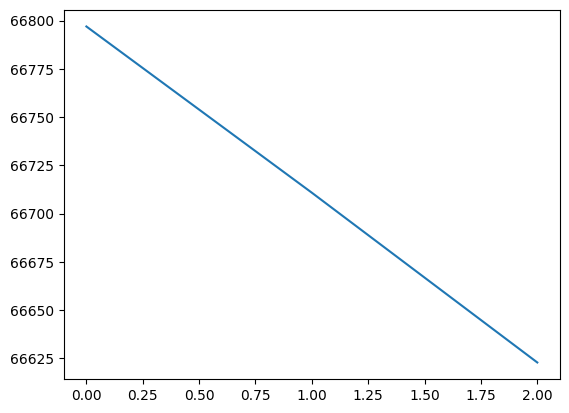

In [48]:
# 학습과정 가시화
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.show()


In [49]:
# 모델 평가
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_scaled, y_test.values))
test_dataset = test_dataset.shuffle(len(test_dataset)).batch(1)
results = model.evaluate(test_dataset)
print(f"test loss: {results}")

3897/3897 [==============================] - 43s 11ms/step - loss: 13081.4229
test loss: 13081.4228515625


In [50]:
# 추론
real_data = scaler.transform([[30.4,25.0]])
y_pred = model.predict(real_data)
print(y_pred)

1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 986ms/step
[[1037.9214]]
